### Main notebook for aircraft TIR imagery analysis

In [1]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime as dt
from datetime import timedelta
from scipy import stats
import math

***
### Functions:

In [2]:
def find_nearest_xy(x_array, y_array, values):
    # input an array of X pixel values, and an array of Y pixel values
    # input also a pair of X,Y values to search for
    # find the index for the pixel with the shortest distance to the target X,Y values
    x_target = values[0];
    y_target = values[1];
    # add half a pixel width to both X and Y arrays so that the location we
    # search for is in the middle of the pixel and not the edge of the pixel
    # calculate this pixel UTM coords for the px centers by taking the average of adjacent px coords
    x_array = np.vstack([(j+i)/2 for i, j in zip(x_array[:-1,:-1], x_array[1:,1:])])
    y_array = np.vstack([(j+i)/2 for i, j in zip(y_array[:-1,:-1], y_array[1:,1:])])
    # calculate the distance between the target position and the pixel center coordinates
    dist = np.sqrt((x_array-x_target)**2 + (y_array-y_target)**2);
    idx = np.unravel_index(np.argmin(dist, axis=None), dist.shape);
    #idx_x = np.unravel_index(np.argmin(dist, axis=None), x_array.shape)
    #idx_y = np.unravel_index(np.argmin(dist, axis=None), y_array.shape)
    min_idx = idx;
    closest_e = x_array[min_idx[0],min_idx[1]];
    closest_n = y_array[min_idx[0],min_idx[1]];
    delta_e = e - closest_e;
    delta_n = n - closest_n;
    delta = [delta_e, delta_n]
    #return x_array[idx_x], y_array[idx_y], idx_x, idx_y
    return dist, idx, delta
 
def create_histogram(image, n_bins=None):
    '''creates a single image's histogram  '''
    # reshape the image pixel array
    image = image.reshape(-1);
    # remove NaN values
    image = image[~np.isnan(image)];
    # create the histogram:
    if n_bins is None:
        n_bins = int(np.round(max(image) - min(image),0)) # bin width should be set to accuracy of the camera? +/- 1 C
    count, value = np.histogram(image, bins=n_bins); 
    # take the bin edges (value) and change them to bin centers
    # so that number of "count" = number of "value"
    new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
    value = new_value
    count_stddev = np.std(count)
    return [value, count]

def getSummaryStats(image):
    i_mean = np.mean(image)
    i_median = np.median(image)
    i_std = np.std(image)
    i_max = np.max(image)
    i_min = np.min(image)
   
    return [i_mean, i_median, i_std, i_max, i_min]

def rmse(value, predictions):
    error = np.array(predictions) - np.array(value)
    SE = error**2
    MSE = np.mean(SE)
    RMSE = np.sqrt(MSE)
    mean_bias = np.mean(error)
    return RMSE, mean_bias

In [3]:
def exportData(this_fname, orig_fname, temps):
    # Combine data into array:
    out_data = np.column_stack([temps])
    # Write out to file:
    with open(this_fname+'.csv','wb') as f:
        np.savetxt(f, out_data, delimiter=",", fmt="%s", header='Temp. (deg C)')

In [4]:
def cleanhist(x, n_bins=None, ax=None, style='line'):
    
    if n_bins is None:
        n_bins = int(np.round(max(x) - min(x),0)) # bin width default to +/- 1
    count, value = np.histogram(x, bins=n_bins); 
    # take the bin edges (value) and change them to bin centers
    # so that number of "count" = number of "value"
    new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
    value = new_value
    
    median_x = np.median(x)
    mean_x = np.mean(x)
    mode_x = value[count.argmax()]  
    #print('Mean:\t%f\nMedian:\t%f\nMode:\t%f' % (mean_x, median_x, mode_x))
    
    if ax == None: # if no axis was specified, create a new figure
        fig = plt.figure(figsize=(5,5),frameon=False)
        ax = fig.add_subplot(1, 1, 1)
    
    if style == 'bar':
        ax.bar(value, count, width=0.4, color='k', edgecolor='k')
    else: # default to 'line' style histogram
        ax.fill_between(value,count,0,color='0.5',alpha=0.1)
        ax.plot(np.linspace(0,0,10),np.linspace(0,np.max(count)+1,10),'-',c='lightgray',label='0 C', linewidth=1)
        ax.plot(value,count,'-k', linewidth=1)
        
    ax.xaxis.grid(which='major', color='lightgray', linestyle=':', linewidth=0.7)
    ax.set_xlabel('Temperature (C)')
    ax.set_ylabel('Number of Samples')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim((0,np.max(count)+1))
    ax.set_xlim((-2,25))
    plt.tight_layout()
    

In [5]:
def findBulkForestTemp(value,count):
    '''We can see from the histogram that forest canopy temperatures have a peak around 10-15 C
    This function retrieves that "forest peak" value as a representation of image-wide "bulk" forest temperature'''
    fmin=10; fmax=20;
    forest_peak = np.max(count[(value>fmin) & (value<fmax)])
    #plt.plot(value[count==forest_peak],forest_peak,'.k')
    
    return value[count==forest_peak].mean()

In [6]:
def quickstats(data,printout=True):
    # remove nans
    data = data[~np.isnan(data)]
    # quick stats
    stats = {
        'mean' : np.mean(data),
        'median' : np.median(data),
        'std' : np.std(data),
        'min' : np.min(data),
        'max' : np.max(data)
    }
    if printout == True:
        print(stats)
    return stats

***
### Load in aircraft TIR data:

In [7]:
# This is the path where you want to search
path = 'Sagehen_IR_project\Sagehen IR Project\UW aircraft data\v1'

# Path to un-calibrated data (raw, DN)
#path = 'Sagehen_IR_project\Sagehen IR Project\UW aircraft data\v2'

# we want to look for files with the .mat extention
extension = '.mat'

# (True) load all images, or (False) only those that overlap a point of interest (e,n)
all_images = False;

# Find only the images that overlap our field site point of interest:
e =  737612.5; # UTM Eastings (m)
n = 4368312.6; # UTM Northings (m)

# start some empty lists to populate below
time_series = []
temp_series = []
UTMe_series = []
UTMn_series = []

# buffer around point, in units of px row/col
buffer = 0

# start a count of images for a new data array
c = 0
# create empty lists to hold images, index of point of interest, delta
image_temp_data = []
image_raw_data = []
image_raw_mean = []
image_raw_mean_offset = []
image_utme_data = []
image_utmn_data = []
image_elev_data = []
image_mean_elev_data = []
image_idx_data = []
image_delta_data = []
# empty lists for aircraft flight data
aircraft_pitch = []
aircraft_azimuth = []
aircraft_roll = []
aircraft_utme = []
aircraft_utmn = []
aircraft_alt = []
aircraft_datetime = []
# empty list for filenames
filenames = [];

# search through the specified directory for the .mat files we want
file = 1;
for root, dirs_list, files_list in os.walk(path):
    for file_name in files_list:
        if os.path.splitext(file_name)[-1] == extension:
            file_name_path = os.path.join(root, file_name)
            #print(file_name)        # This prints just the file name
            #print(file_name_path)   # This prints the full file path
            
            # read in this mat file
            aircraft_data = sio.loadmat(file_name_path)
            
            # get image dimensions (x,y), and number of images (z) within this mat file
            x,y,z = aircraft_data['calCam1'].shape

            # start count of images we'll want to query later
            i = 0
            image_list = []

            if all_images == False:
                # for each image in this file, check if our field site is included in the frame
                for image in range(0,z):
                    # calculate for each image, the minimum distance between it and the point of interest at (e,n)
                    [dist, idx, delta] = find_nearest_xy(aircraft_data['X1'][:,:,image], aircraft_data['Y1'][:,:,image],[e,n])
                    if np.abs(delta[0]) < 1 and np.abs(delta[1]) < 1:
                            # if the minimum distance is less than 1 meter, then load the image
                            print(file_name, image, delta)
                            filenames.append(file_name[:-4])
                            image_list.append(image);
                            image_temp_data.append(aircraft_data['calCam1'][:,:,image])
                            try: # if the file also contains raw (DN) images, we read that in too
                                image_raw_data.append(aircraft_data['rawCam1'][:,:,image])
                                image_raw_mean.append(aircraft_data['mean1'])
                                image_raw_mean_offset.append(aircraft_data['mn1off'])
                            except KeyError:
                                print('No raw data to load')
                            image_utme_data.append(aircraft_data['X1'][:,:,image])
                            image_utmn_data.append(aircraft_data['Y1'][:,:,image])
                            image_elev_data.append(aircraft_data['Z1'][:,:,image])
                            image_mean_elev_data.append(np.mean(image_elev_data))
                            image_idx_data.append(idx)
                            image_delta_data.append(delta)
                            # parse out aircraft position and orientation here
                            planeAHP = aircraft_data['planeAHP'][image,:]
                            aircraft_pitch.append(planeAHP[0])
                            aircraft_azimuth.append(planeAHP[1])
                            aircraft_roll.append(planeAHP[2])
                            aircraft_utme.append(planeAHP[3])
                            aircraft_utmn.append(planeAHP[4])
                            aircraft_alt.append(planeAHP[5])
                            aircraft_datetime.append(aircraft_data['datenumCam1'][:,image])
                            i = i + 1; # incriment to count the number of images we load

            elif all_images == True:
                # alternatively, load all images for analysis
                for image in range(0,z):
                    # add each image to our list
                            print(file_name, image)
                            filenames.append(file_name[:-4])
                            image_list.append(image);
                            image_temp_data.append(aircraft_data['calCam1'][:,:,image])
                            try: # if the file also contains raw (DN) images, we read that in too
                                image_raw_data.append(aircraft_data['rawCam1'][:,:,image])
                                image_raw_mean.append(aircraft_data['mean1'])
                                image_raw_mean_offset.append(aircraft_data['mn1off'])
                            except KeyError:
                                print('No raw data to load')
                            image_utme_data.append(aircraft_data['X1'][:,:,image])
                            image_utmn_data.append(aircraft_data['Y1'][:,:,image])
                            image_elev_data.append(aircraft_data['Z1'][:,:,image])
                            image_mean_elev_data.append(np.mean(image_elev_data))
                            # parse out aircraft position and orientation here
                            planeAHP = aircraft_data['planeAHP'][image,:]
                            aircraft_pitch.append(planeAHP[0])
                            aircraft_azimuth.append(planeAHP[1])
                            aircraft_roll.append(planeAHP[2])
                            aircraft_utme.append(planeAHP[3])
                            aircraft_utmn.append(planeAHP[4])
                            aircraft_alt.append(planeAHP[5])
                            aircraft_datetime.append(aircraft_data['datenumCam1'][:,image])
                            i = i + 1; # incriment to count the number of images we load
                            
                            
# Calculate horizontal offset due to roll and pitch angles
h = [i - j for i, j in zip(aircraft_alt, image_mean_elev_data)] # altitude - mean ground elevation = altitude AGL
r = aircraft_roll
p = aircraft_pitch
x = h * np.tan(np.radians(r))
y = h * np.tan(np.radians(p))
z = np.sqrt(x**2 + y**2)
view_angle = np.degrees(np.arctan(z/h)) # view angle from nadir at image center


# Convert to python datetime format
aircraft_datetime = np.array(aircraft_datetime)
aircraft_dt = [timedelta(days=x[0]-366)+dt(1,1,1) for x in aircraft_datetime]

SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 39 [-0.3852862138301134, -0.31791679188609123]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 40 [-0.2190698516787961, -0.26197327859699726]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 41 [0.414569687563926, -0.13851027935743332]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 42 [0.5776131853926927, 0.37504844553768635]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 43 [0.24903246783651412, 0.37370725255459547]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 44 [-0.2955534582724795, 0.3101054821163416]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2116UTC_cam1Data.mat 45 [-0.44248811178840697, -0.3592105256393552]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2122UTC_cam1Data.mat 52 [-0.5505501516163349, 0.28048265911638737]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2125UTC_cam1Data.mat 31 [0.29518277279566973, 0.2352649094536

SAGEHEN_IR_PLANE_2017Apr21_2147UTC_cam1Data.mat 68 [0.16456412873230875, -0.4096017014235258]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2147UTC_cam1Data.mat 69 [-0.0010853341082111, 0.2425300357863307]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 33 [0.0715258423006162, -0.12799558509141207]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 34 [-0.1507482237648219, -0.40244195610284805]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 35 [0.00920828152447939, -0.2522013559937477]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 36 [0.26901830604765564, 0.4245758866891265]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 37 [-0.0948893919121474, -0.6288997204974294]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 38 [-0.5322678294032812, -0.07229784317314625]
No raw data to load
SAGEHEN_IR_PLANE_2017Apr21_2150UTC_cam1Data.mat 39 [-0.29220363148488104, -0.41123849339

In [9]:
# replace the calCam with rawCam data if we want to look at the raw data
#image_temp_data = image_raw_data

***
### Radiometric correction using the surface temperature signal of melting snow
First, determine the radiometric correction needed for each image loaded.

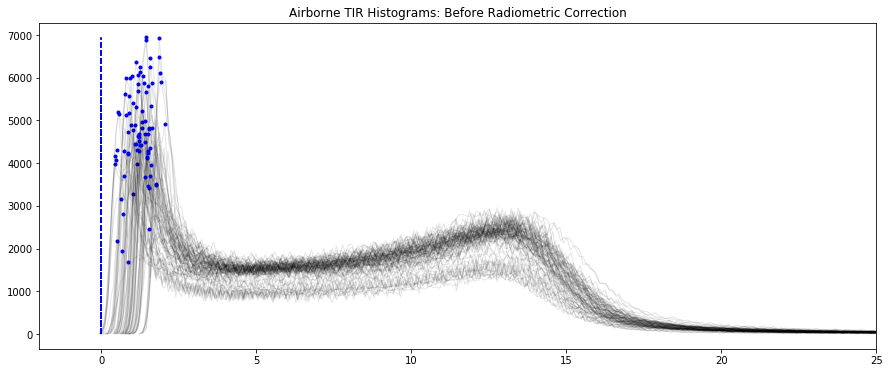

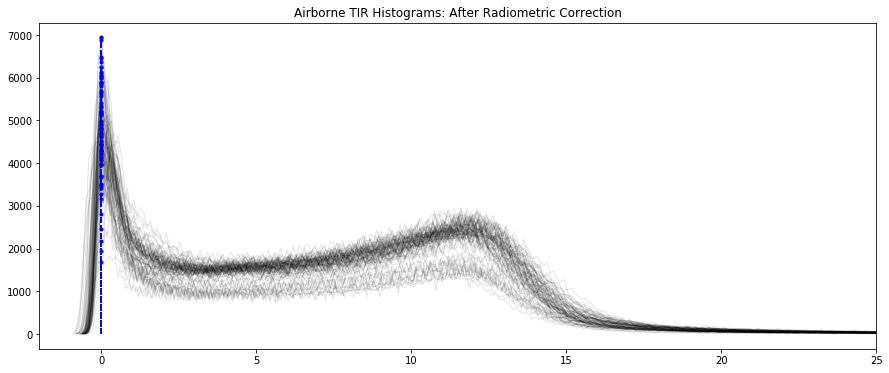

In [8]:
data_counter = 0;
# make empty lists to hold the histogram offset values
hist_offsets = [];
offsets = [];
bulkForestT = [];
bulkForestT_nocorrection = [];

for img in range(0,len(image_temp_data)):
    # reshape the image pixel array and remove NaN values before generating a histogram
    image = image_temp_data[data_counter].reshape(-1);
    image = image[~np.isnan(image)];
    
    # find all peaks in the histogram:
    nbins = np.ceil(np.sqrt(640*480)).astype(np.int16) # using sqrt to determine the number of bins to use
    value, count = create_histogram(image,nbins)
    count_stddev = np.std(count)

    modes = []
    counts = []
    for i in range(1,count.shape[0]-1):
        # if the count at this index is a local maximum based on its two neighbors
        if count[i-1] < count[i] and count[i+1] < count[i]:
            #print('peak at i=',i)
            modes.append(value[i])
            counts.append(count[i])
    
    # find the "snow peak" -- looking for the coldest peak in the image's histogram
    #print('snow peak:', modes[0])
    # set the histogram offset to this minimum peak, so that the peak will be the new 0 deg C point
    hist_offset = modes[0]
    offsets.append(hist_offset)

    # plot original histogram with mark at Tss = 0
    plt.figure(0,figsize=(15,6))
    plt.plot(value,count,alpha=.1,linewidth=1,color=(0,0,0))
    plt.plot(np.linspace(0,0),np.linspace(0,np.max(count)),'--b',alpha=1)
    plt.plot(modes[0],counts[0],'.b')
    plt.xlim([-2,25])
    plt.title("Airborne TIR Histograms: Before Radiometric Correction")
    bulkForestT_nocorrection.append(findBulkForestTemp(np.array(value),np.array(count)))
       
    plt.figure(1,figsize=(15,6))
    # Don't apply the offset if there isn't an apparent snow peak 
    # Defining this here as within 4 degrees of expected Tss
    if hist_offset > 4:
        hist_offsets.append(0);
        data_counter = data_counter + 1;   
        plt.plot(value,count,alpha=1,linewidth=1,color=(1,0,0)) 
    else: # Add the hist_offset to the list of all hist_offsets and plot
        hist_offsets.append(hist_offset);
        data_counter = data_counter + 1;
        plt.plot(value - hist_offset,count,alpha=.1,linewidth=1,color=(0,0,0))
        bulkForestT.append(findBulkForestTemp(value - hist_offset,count))
    
    plt.plot(modes[0] - hist_offset,counts[0],'.b')    
    plt.plot(np.linspace(0,0),np.linspace(0,np.max(count)),'--b',alpha=1)
    plt.title("Airborne TIR Histograms: After Radiometric Correction")  
    plt.xlim([-2,25])
        

# Save these histogram figures:
#plt.figure(0)
#plt.savefig('sagehen_aircraft_hist_before_correction.png', dpi=300)
#plt.figure(1)
#plt.savefig('sagehen_aircraft_hist_after_correction.png', dpi=300)   


#### Calculate some summary statistics about these biases

In [9]:
Tss = 0
print('Mean hist offset:',np.mean(hist_offsets))
rmse_tss, mean_bias_tss = rmse(Tss,hist_offsets)
print('RMSE before correction: ', rmse_tss)
print('Mean Bias before correction: ', mean_bias_tss)
print('Max error before correction: ',np.max(hist_offsets))
print('Min error before correction: ',np.min(hist_offsets))
print('Std error before correction: ',np.std(hist_offsets))
print('Mean error before correction: ',np.mean(hist_offsets))
print('Median error before correction: ',np.median(hist_offsets))

Mean hist offset: 1.2147734397869603
RMSE before correction:  1.2729738480274515
Mean Bias before correction:  1.2147734397869603
Max error before correction:  2.0432848803096273
Min error before correction:  0.43862438658639813
Std error before correction:  0.3805100626132954
Mean error before correction:  1.2147734397869603
Median error before correction:  1.22781344016475


#### Plot a histogram of all bias values

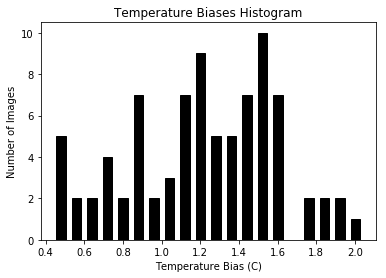

In [10]:
hist_bias = hist_offsets
# Make a histogram of how far our snow peaks were from the expected Tss=0
count, value = np.histogram(hist_bias, bins=20); 
#percent = (count/(len(hist_bias)))*100
new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
value = new_value
plt.figure(99)
plt.bar(value, count, width=0.05, color='k', edgecolor='k')
plt.title('Temperature Biases Histogram')
#plt.ylim((0,100)); plt.xlim((0,15)); 
plt.ylabel('Number of Images');
plt.xlabel('Temperature Bias (C)');
#plt.savefig('sagehen_aircraft_biases_before_correction_sqrtBins_all.png', dpi=600)

#### Plot the bias value over time

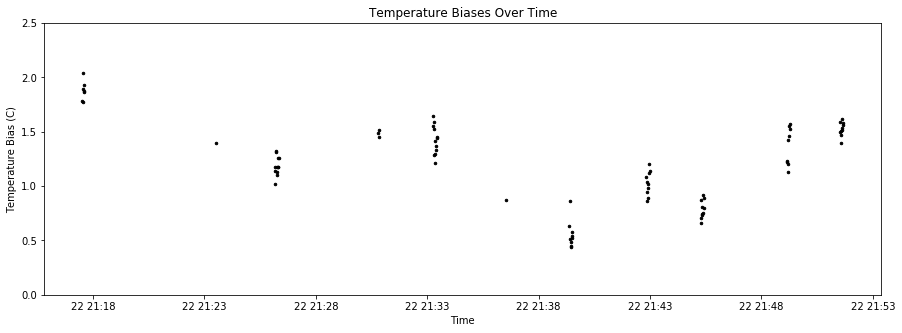

In [11]:
plt.figure(100,figsize=(15,5))
plt.plot(aircraft_dt, hist_bias,'.k',markersize=5)
plt.title('Temperature Biases Over Time')
plt.ylim((0,2.5)); 
plt.xlabel('Time');
plt.ylabel('Temperature Bias (C)');
#plt.savefig('sgehen_aircraft_biases_before_correction_series_plot_all.png', dpi=600)

#### Finally, apply the bias corrections to each image

In [12]:
# Or don't apply and revert our hist_offsets all to zero
#hist_offsets = np.zeros(len(image_temp_data))

img_temp_data = np.array(image_temp_data) - np.array(hist_offsets[0])
img_temp_data.shape

(84, 480, 640)

***
#### Set Areas of Interest (AOIs):

In [13]:
# ID     Easting    Northing    Description
# 0      737612.5   4368312.6   instrumented small meadow tree
# 1      737563     4368190     dense trees
# 2      737633     4368292     sagehen creek 1
# 3      737660     4368308     sagehen creek 2
# 4      737685     4368304     sagehen creek 3
# 5      737815     4368300     USGS 10343500 SAGEHEN C NR TRUCKEE CA https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10343500
# 6      737597     4368429     forest gap snow surface temperature (10m north1)
# 7      737607     4368403.5   forest gap snow surface temperature (12x5m north2)
# 8      737624     4368396     forest gap snow surface temperature (8m north3)
# 9      737627     4368341     forest gap snow surface temperature (10x4m center1)
# 10     737613     4368338     forest gap snow surface temperature (5x2m center2)
# 11     737615     4368336     forest gap snow surface temperature (5x2m center3)
# 12     737623     4368277     forest gap snow surface temperature (13x7m south1)
# 13     737639     4368278     forest gap snow surface temperature (5x2m south2)
# 14     737620     4368307     snow surface temperature in the middle of the meadow (Tss to compare with radiometer)


# Choose a point of interest to focus on:
points_e = [737612.5, 737563, 737633, 737660, 737685, 737815,
            737615,737613,737639,
            737627,737607,737623,737624,737597,737620]
points_n = [4368312.6, 4368190, 4368292, 4368308, 4368304, 4368300,
            4368336,4368338,4368278,
            4368341,4368403.5, 4368277,4368396, 4368429,4368307]
fnames = ['instrumented_tree','dense_tree_stand','sagehen_creek_1','sagehen_creek_2','sagehen_creek_3','sagehen_creek_4',
          'forest_gap_5x2m_2','forest_gap_5x2m_1','forest_gap_5x2m_3',
          'forest_gap_10x4m','forest_gap_12x5m','forest_gap_13x7m','forest_gap_8x8m','forest_gap_10x10m','instrumented_snow']

fpath = '\Sagehen_IR_project\plots\aircraft ir\AOIs'


#### Correct geolocation for AOIs

In [14]:
# Because the geolocation of these aerial images isn't exact, I'm going to make a manual
# list of the UTM E and N location of the center of the instrumented tree for each of
# the 84 aerial images:

utme_original = np.array([737612.5, 737611, 737607.5, 737607, 737606, 737605, 737606.5, 737596, 737612.5, 737604.5, 737613, \
       737607, 737610, 737611, 737614, 737614, 737614, 737613, 737613, 737610, 737594, 737594, 737593, \
       737608, 737609, 737612.5, 737610, 737608, 737611, 737612, 737613.5, 737615.5, 737615.5, 737615, \
       737615, 737579, 737612.5, 737612, 737612, 737608, 737611, 737612, 737611, 737610.5, 737607, 737595, \
       737596.5, 737599, 737600, 737603, 737604, 737605, 737605, 737611, 737608, 737612, 737612, 737611, \
       737608, 737611, 737611, 737609.5, 737610, 737610, 737607.5, 737598, 737596, 737597, 737595, 737594, \
       737591, 737589, 737590, 737588, 737610, 737608, 737613.5, 737611.5, 737614, 737617.5, 737615, \
       737614, 737617, 737613])

utmn_original = np.array([4368312.5, 4368311, 4368310, 4368307, 4368304, 4368299, 4368300.5, 4368302, 4368314, 4368309, 4368310, \
       4368307, 4368302, 4368302, 4368299, 4368298, 4368298, 4368293, 4368293, 4368290, 4368317, 4368318, 4368321, \
       4368317, 4368313.5, 4368307, 4368306.5, 4368307, 4368300, 4368305, 4368304, 4368299.5, 4368297.5, 4368293, \
       4368292, 4368308, 4368313, 4368310, 4368307.5, 4368305, 4368304, 4368304, 4368302, 4368296, 4368304, 4368305, \
       4368309, 4368307.5, 4368313, 4368313, 4368318, 4368319, 4368321, 4368322, 4368324, 4368307, 4368308, 4368307.5, \
       4368303, 4368301, 4368299, 4368297, 4368297, 4368294, 4368292.5, 4368298, 4368301, 4368301, 4368302, 4368306, \
       4368307.5, 4368311, 4368315, 4368317.5, 4368313, 4368311, 4368310.5, 4368307.5, 4368307, 4368300, 4368300, \
       4368296, 4368297, 4368292])

e =  737612.5; # UTM Eastings (m)
n = 4368312.6; # UTM Northings (m)

utme_delta = utme_original - e # difference between "known" point and manually identified point, UTM Eastings (m)
utmn_delta = utmn_original - n # difference between "known" point and manually identified point, UTM Northings (m)


#### Set run decisions for retriving temperatures for all AOIs:

In [15]:
new_plot = False; # make plots for figure(s)
save_images = False; # saving figures
export_data = False; # exports data as csv for each AOI

window = 1; # set window=1 for a 3x3 grid centered at point of interest

buffer = 20; # set buffer in number of pixels around the AOI point for plotting

#### Run Main Analysis (retrieve temperatures for all AOIs):

In [16]:
n_px = (1+window*2)**2 # number of pixels in this window
temps_all = np.ones((len(utme_original)*n_px,len(fnames))); # start with an empty array

# For each point in our list of AOIs
for pt in range(0,len(points_e)):
    print('Retrieving temperature of {}'.format(fnames[pt]))
    fname = fpath + '\\' + fnames[pt] # creating a filepath+name for the AOI
    point_e = points_e[pt] # get eastings
    point_n = points_n[pt] # get northings

    # set offset for a different point of interest
    # how far from our previous point of interest is this new point?
    offset_e = point_e - e
    offset_n = point_n - n
    # shift our arrays of utm coordinates to the new point
    utme = utme_original + offset_e
    utmn = utmn_original + offset_n

    # get the temperature of this point across all images:
    temps = [];
    row = 0;
    for i in range(0,len(utme)):
        [dist, idx, delta] = find_nearest_xy(image_utme_data[i],image_utmn_data[i],[utme[i],utmn[i]])
        if window==0:
            no_window = image_temp_data[i][idx[0],idx[1]]
            temps.append(no_window)
            temps_all[row,pt] = no_window
            row = row + 1;
        else: # if we have a window of pixels, add all their values into the temps array:
            pixel_window = image_temp_data[i][idx[0]-window:idx[0]+window+1,idx[1]-window:idx[1]+window+1]
            if pixel_window.size != 0:
                for px,value in enumerate(np.hstack(pixel_window)):
                    temps.append(value)
                    temps_all[row,pt] = value
                    row = row + 1;
        
        # plotting routine:
        if new_plot == True:
            # set plot resolution and filename:
            fname = fname # setting filename above
            dpi=300

            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
            tir = ax1.pcolor(image_utme_data[i],image_utmn_data[i], \
                                image_temp_data[i], cmap=plt.cm.magma, \
                                vmin=0, vmax=20)
            ax1.plot(utme[i],utmn[i],'wx')
            ax1.axis('off')
            # set axes limits to our specified buffer size around the AOI
            ax1.set_xlim((utme[i]-buffer,utme[i]+buffer))
            ax1.set_ylim((utmn[i]-buffer,utmn[i]+buffer))
            fig.colorbar(tir, ax=ax1)

            ax1.set_title('TIR Image {}'.format(i))

            # plot a histogram
            cleanhist(temps,10,ax2)
            ax2.set_title('AOI Temperature Histogram'.format(i))
            plt.tight_layout()

            if save_images == True:
                plt.savefig(fname+'_'+str(i)+'_tir_.png',dpi=dpi,bbox_inches='tight', transparent=False, pad_inches=0)
                plt.close('all')

                
    # export data after looking at the AOI in all images in the collection
    if export_data == True:
        # I can reconstruct the 3x3 pixel grid I sampled with this:
        #temps_reshaped = np.array(temps).reshape((84, 3, 3))
        # Or to a single row for each image like this:
        #temps_reshaped = np.array(temps).reshape(len(utme)/9, 9)
        # Export the data:
        exportData(fname, filenames, temps);
        



Retrieving temperature of instrumented_tree
Retrieving temperature of dense_tree_stand
Retrieving temperature of sagehen_creek_1
Retrieving temperature of sagehen_creek_2
Retrieving temperature of sagehen_creek_3
Retrieving temperature of sagehen_creek_4
Retrieving temperature of forest_gap_5x2m_2
Retrieving temperature of forest_gap_5x2m_1
Retrieving temperature of forest_gap_5x2m_3
Retrieving temperature of forest_gap_10x4m
Retrieving temperature of forest_gap_12x5m
Retrieving temperature of forest_gap_13x7m
Retrieving temperature of forest_gap_8x8m
Retrieving temperature of forest_gap_10x10m
Retrieving temperature of instrumented_snow


#### Plot time series of the temperature of each AOI

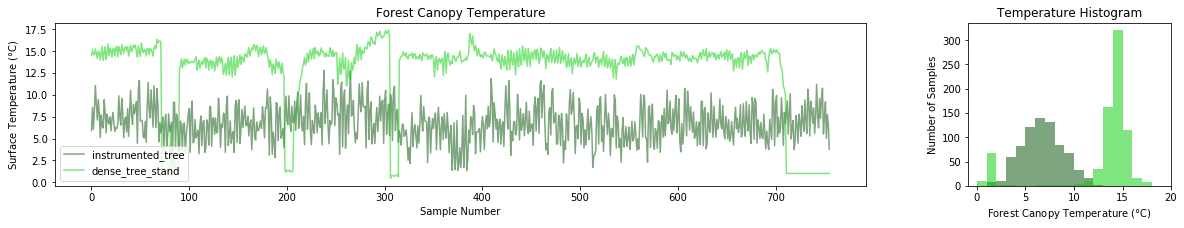

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,3),gridspec_kw={'width_ratios': [4, 1]})

c = 0
for i in range(0,2): # for the two tree canopies sampled
    # time series
    ax1.plot(temps_all[:,i],color=(0,c+0.3,0),label=fnames[i],alpha=0.5);
    # histogram
    ax2.hist(temps_all[:,i],
             bins=range(0,20,1),
             color=(0,c+0.3,0),alpha=0.5);
    # print out some stats if we want:
    #quickstats(temps_all[:,i])
    #rmse_tree, meanbias = rmse(16.9,temps_all[:,i])
    #print('RMSE:',rmse_tree)
    #print('Mean Bias:', meanbias)
    c+=0.5

ax1.legend()
ax1.set_title('Forest Canopy Temperature')
ax1.set_ylabel('Surface Temperature ($\degree$C)')
ax1.set_xlabel('Sample Number')

ax2.set_title('Temperature Histogram')
ax2.set_ylabel('Number of Samples')
ax2.set_xlabel('Forest Canopy Temperature ($\degree$C)');


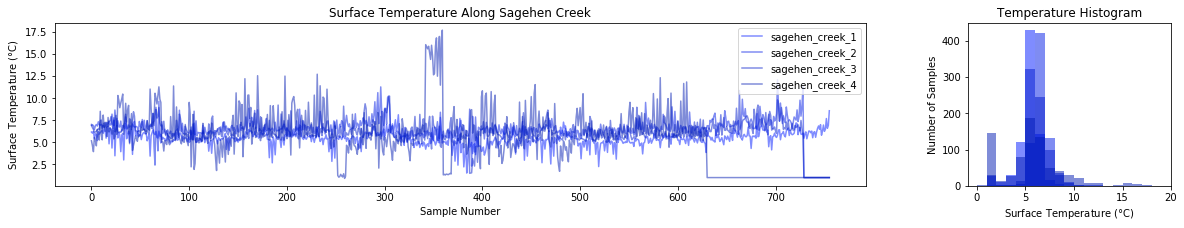

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,3),gridspec_kw={'width_ratios': [4, 1]})

c = 0
for i in range(2,6): # for each sample point along Sagehen Creek
    # time series
    ax1.plot(temps_all[:,i],color=(0,0.1,1-c),label=fnames[i],alpha=0.5);
    # histogram
    ax2.hist(temps_all[:,i],
             bins=range(0,20,1),
             color=(0,0.1,1-c),alpha=0.5);
    # print out some stats if we want:
    #quickstats(temps_all[:,i])
    #rmse_tree, meanbias = rmse(4.5,temps_all[:,i])
    #print('RMSE:',rmse_tree)
    #print('Mean Bias:', meanbias)
    c+=0.1

ax1.legend()
ax1.set_title('Surface Temperature Along Sagehen Creek')
ax1.set_ylabel('Surface Temperature ($\degree$C)')
ax1.set_xlabel('Sample Number')

ax2.set_title('Temperature Histogram')
ax2.set_ylabel('Number of Samples')
ax2.set_xlabel('Surface Temperature ($\degree$C)');


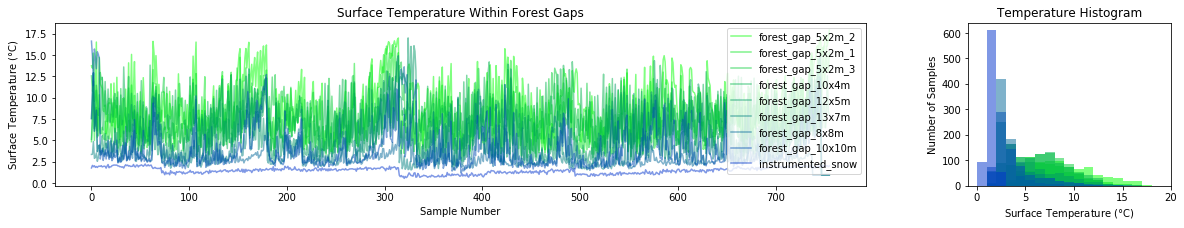

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,3),gridspec_kw={'width_ratios': [4, 1]})

c = 0
for i in range(6,15): # for each forest gap AOI id
    # time series
    ax1.plot(temps_all[:,i],color=(0,1-c,c),label=fnames[i],alpha=0.5);
    # histogram
    ax2.hist(temps_all[:,i],
             bins=range(0,20,1),
             color=(0,1-c,c),alpha=0.5);
    # print out some stats if we want:
    #quickstats(temps_all[:,i])
    #rmse_tree, meanbias = rmse(0,temps_all[:,i])
    #print('RMSE:',rmse_tree)
    #print('Mean Bias:', meanbias)
    c+=0.1

ax1.legend()
ax1.set_title('Surface Temperature Within Forest Gaps')
ax1.set_ylabel('Surface Temperature ($\degree$C)')
ax1.set_xlabel('Sample Number')

ax2.set_title('Temperature Histogram')
ax2.set_ylabel('Number of Samples')
ax2.set_xlabel('Surface Temperature ($\degree$C)');


#### Boxplots of temperatures for each point of interest retrieved above

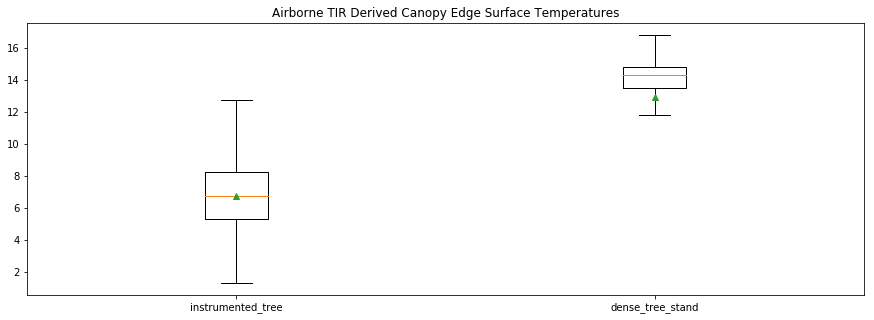

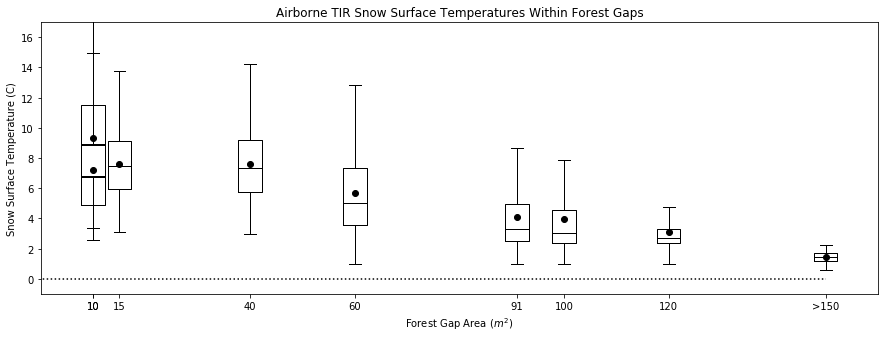

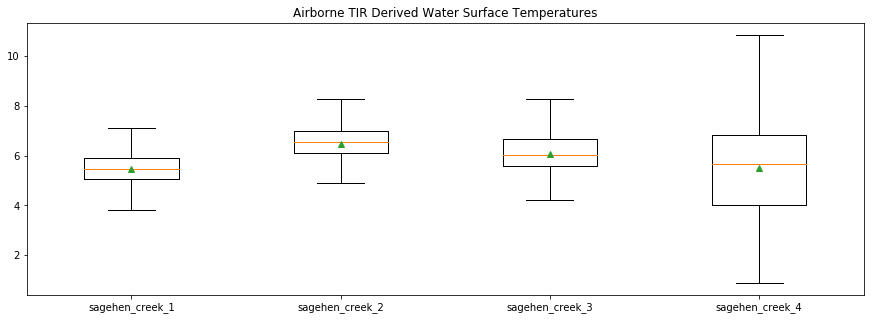

In [20]:
lbls = ['instrumented_tree','dense_tree_stand','sagehen_creek_1','sagehen_creek_2','sagehen_creek_3','sagehen_creek_4',
          '2','2','2',
          '4','5','7','8','10','>20']
gap_areas = [10,10,15,40,60,91,120,100,150]
gap_area_labels = ['10','10','15','40','60','91','120','100','>150']
pos = [2,2,2,4,5,7,8,10,20];

plt.figure(0,figsize=(15,5))
plt.title('Airborne TIR Derived Canopy Edge Surface Temperatures')
plt.boxplot(temps_all[:,0:2],labels=lbls[0:2],showmeans=True,showfliers=False);
#plt.savefig('Airborne TIR Derived Canopy Edge Surface Temperatures 1px.png',dpi=600)

plt.figure(2,figsize=(15,5))
plt.title('Airborne TIR Snow Surface Temperatures Within Forest Gaps')
#plt.violinplot(temps_all[:,6:15], pos, points=100, widths=.9, showmeans=False, showextrema=False, showmedians=False);
#plt.boxplot(temps_all[:,6:15],labels=lbls[6:15],showmeans=True,showfliers=True,positions=pos);
black_dots_mean = dict(markerfacecolor='k', marker='o',markeredgecolor='k')
black_lines_median = dict(color='k')
plt.boxplot(temps_all[:,6:15],labels=gap_area_labels,showmeans=True,meanprops=black_dots_mean,
            medianprops=black_lines_median,showfliers=False,positions=gap_areas,widths=4.5);
plt.plot(np.linspace(-10,150,2),np.linspace(0,0,2),':k')
plt.xlim((0,160))
plt.ylim((-1,17))
plt.ylabel('Snow Surface Temperature (C)')
plt.xlabel('Forest Gap Area ($m^2$)')
#plt.savefig('Airborne TIR Snow Surface Temperatures Within Forest Gaps all.png',dpi=600)

plt.figure(1,figsize=(15,5))
plt.title('Airborne TIR Derived Water Surface Temperatures')
plt.boxplot(temps_all[:,2:6],labels=lbls[2:6],showmeans=True,showfliers=False);
#plt.savefig('Airborne TIR Derived Water Surface Temperatures.png',dpi=600)

***
***
### Look at the effect of view angle on surface temperature retrievals
Make a map of view angles for every pixel, given that our camera's IFOV = 0.0625 degrees / px

C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


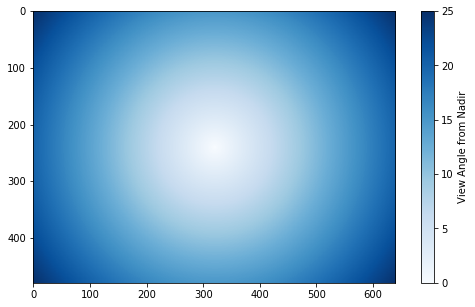

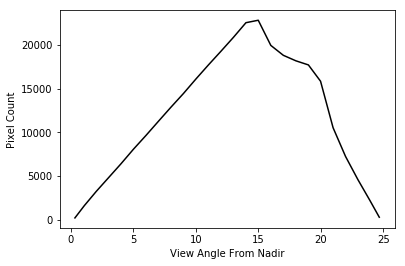

In [89]:
angles = np.ones((480,640)); # blank array for view angles

centerpxX = 640/2
centerpxY = 480/2
IFOV = 0.0625

# Using the IFOV, calculate angles from nadir (center pixel) for each pixel
for y in range(0,angles.shape[0]):
    for x in range(0,angles.shape[1]):
        xdist = np.abs(centerpxX - x)
        ydist = np.abs(centerpxY - y)
        dist = np.sqrt((xdist)**2 + (ydist)**2)
        angles[y,x] = IFOV * dist

        
# Plot a colored map of view angles from nadir (center pixel)
plt.figure(0,figsize=(9,5))
plt.imshow(angles,cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('View Angle from Nadir')
#plt.savefig('viewangle_.png',dpi=300)



# Plot the number of pixels in each 1 degree view angle bin
plt.figure(2)
x_all = [];
y_all = [];
for n in [0]:
    x = [];
    y = [];
    for a in range(0,36):
        x.append(np.mean(angles[np.round(angles)==a]))
        y.append(len(img_temp_data[n][np.round(angles)==a]))
        x_all.append(np.mean(angles[np.round(angles)==a]))
        y_all.append(len(img_temp_data[n][np.round(angles)==a]))
    plt.plot(x,y,'-k')
#plt.scatter(x,y,s=1,color='k')
plt.xlabel('View Angle From Nadir')
plt.ylabel('Pixel Count');
#plt.savefig('count_vs_viewAngle.png',dpi=600)

#### Take a look at a sample image (Figure 4b):

(-0.5, 639.5, 479.5, -0.5)

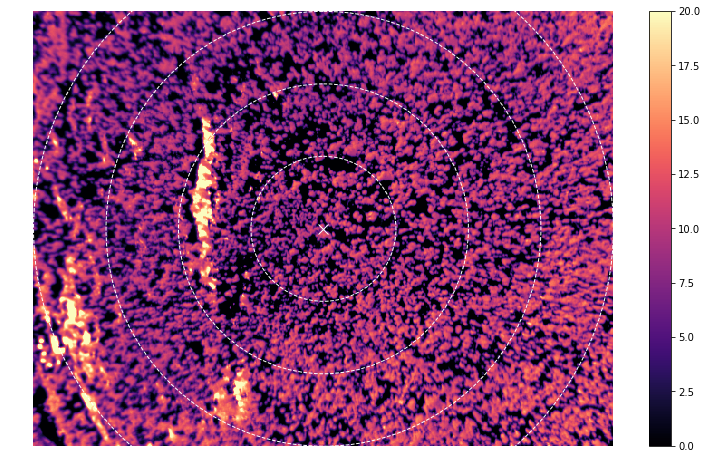

In [92]:
# produces Figure 4b

n=35
fig,ax = plt.subplots(figsize=(13,8))
plt.imshow(img_temp_data[n],cmap='magma',vmin=0,vmax=20)

# plot circles to mark angles from nadir steps of 5 degrees
circle5 = plt.Circle((320, 240), 5/IFOV, color='w', linestyle='--', fill=False)
circle10 = plt.Circle((320, 240), 10/IFOV, color='w', linestyle='--', fill=False)
circle15 = plt.Circle((320, 240), 15/IFOV, color='w', linestyle='--', fill=False)
circle20 = plt.Circle((320, 240), 20/IFOV, color='w', linestyle='--', fill=False)
ax.add_artist(circle5)
ax.add_artist(circle10)
ax.add_artist(circle15)
ax.add_artist(circle20)
# Add a mark at the image center (nadir)
plt.plot(320,240,'xw',markersize=10)

plt.colorbar()
plt.axis('off')

#plt.savefig(str(n)+'_viewangleDemo.png',dpi=600)

#### View Angle vs VGF, Mean T, Std T (Figure S6):

(5, 23)

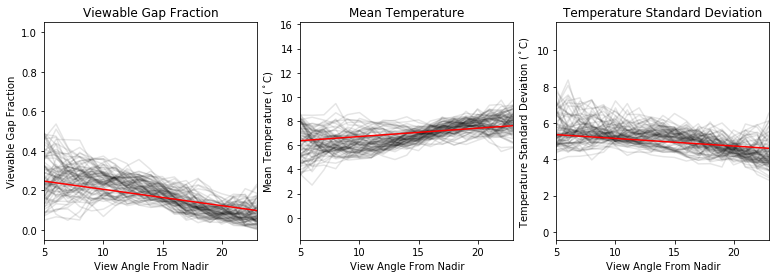

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

# Viewable Gap Fraction (snow pixels)
angle_all = [];
vgf_all = [];
mean_all = [];
std_all = [];
for n in range(84):
    angle = [];
    vgf = [];
    mean = [];
    std = [];
    for a in range(0,int(np.ceil(angles.max()))):
        angle.append(np.mean(angles[np.round(angles)==a])) # find view angle, append for this image
        angle_all.append(np.mean(angles[np.round(angles)==a])) # append all images view angles
        
        n_px = img_temp_data[n][(np.round(angles)==a)].size # count the number of pixels in this view angle bin
        
        snow_px_fraction = img_temp_data[n][(np.round(angles)==a) & (img_temp_data[n]<1)].size / n_px # calculate VGF
        vgf.append(snow_px_fraction) # append this image's VGF      
        vgf_all.append(snow_px_fraction) # append all images VGFs
        
        mixed_px_fraction = img_temp_data[n][(np.round(angles)==a) & (img_temp_data[n]>1) & (img_temp_data[n]<10)].size / n_px # mixed pixel fraction
        canopy_px_fraction = img_temp_data[n][(np.round(angles)==a) & (img_temp_data[n]>10)].size / n_px # canopy pixel fraction
        
        mean.append(np.mean(img_temp_data[n][np.round(angles)==a])) # append this image's mean T
        mean_all.append(np.mean(img_temp_data[n][np.round(angles)==a])) # append all images mean T
        
        std.append(np.std(img_temp_data[n][np.round(angles)==a])) # append this image's std T
        std_all.append(np.std(img_temp_data[n][np.round(angles)==a])) # append all images std T
        
    ax1.plot(angle,vgf,'-k',alpha=0.1) # plot VGF vs view angle for single image
    ax2.plot(angle,mean,'-k',alpha=0.1) # plot mean T vs view angle for single image
    ax3.plot(angle,std,'-k',alpha=0.1) # plot std T vs view angle for single image
    
# Calculate linear regressions for each of the three plots:
# VGF
slope, intercept, r, p, SE = stats.linregress(angle_all,vgf_all)
#print(slope, intercept, r, p, SE)
x_lin = np.linspace(min(x_all),max(x_all),2)
ax1.plot(x_lin, slope*x_lin + intercept, '-r', label='Linear Fit')
ax1.set_title('Viewable Gap Fraction')
ax1.set_xlabel('View Angle From Nadir')
ax1.set_ylabel('Viewable Gap Fraction') # VGF defined as fraction of pixels < 1 C
ax1.set_xlim((5,23))

# Mean T
slope, intercept, r, p, SE = stats.linregress(angle_all,mean_all)
#print(slope, intercept, r, p, SE)
x_lin = np.linspace(min(x_all),max(x_all),2)
ax2.plot(x_lin, slope*x_lin + intercept, '-r', label='Linear Fit')
ax2.set_title('Mean Temperature')
ax2.set_xlabel('View Angle From Nadir')
ax2.set_ylabel('Mean Temperature ($^\circ$C)') # VGF defined as fraction of pixels < 1 C
ax2.set_xlim((5,23))

# Std T
slope, intercept, r, p, SE = stats.linregress(angle_all,std_all)
#print(slope, intercept, r, p, SE)
x_lin = np.linspace(min(x_all),max(x_all),2)
ax3.plot(x_lin, slope*x_lin + intercept, '-r', label='Linear Fit')
ax3.set_title('Temperature Standard Deviation')
ax3.set_xlabel('View Angle From Nadir')
ax3.set_ylabel('Temperature Standard Deviation ($^\circ$C)') # VGF defined as fraction of pixels < 1 C
ax3.set_xlim((5,23))

#plt.savefig('view_angles.png',dpi=300)

***
### Compute azimuth angles for all pixels

In [ ]:
lower_threshold = 1 # try to filter out snow-only pixels with a lower threshold

x_all = []; # azimuth angle (from center of image)
y_all = []; # temperature data (mean)
z_all = []; # local zenith angles (view angles)

# create an empty array for the azimuth angles
azmuth_angles = np.ones_like(image_utme_data); # azimuth angles (compass direction from the point directly nadir)

# For each image
for n in range(84):
    
    # determine the center pixel's UTM coordinates
    centerpxUTME = image_utme_data[n][240][320]
    centerpxUTMN = image_utmn_data[n][240][320]
    
    # for every pixel in this image
    for y in range(0,azmuth_angles[n].shape[0]):
        for x in range(0,azmuth_angles[n].shape[1]):
            
            # Calculate the distance of this pixel from the image center in UTM Northings and Eastings
            E_dist = centerpxUTME - image_utme_data[n][y][x]
            N_dist = centerpxUTMN - image_utmn_data[n][y][x]
            
            # Calculate the azimuth angle
            azmuth_angles[n][y][x] = (np.degrees(-1*math.atan2(N_dist,E_dist)) + 360 + 90) % 360
            
            # append local zenith angles to this "z" array 
            # (sort of a proxy for height, or at least how much of the tree we can see vertically)
            #z_all.append(angles[y][x])

    # for every 1 degree azimuth angle
    for a in range(0,360):
        
        # Calculate the mean angle for any pixels that fall into this 1 degree azimuth bin
        x_all.append(np.mean(azmuth_angles[n][np.round(azmuth_angles[n])==a]))
        
        # Calculate the mean temperature for any pixels that fall into this 1 degree azimuth bin
        y_all.append(np.mean(img_temp_data[n][(np.round(azmuth_angles[n])==a) & 
                                             (img_temp_data[n] > lower_threshold)]))
        
    #plt.plot(x,y,'-k',alpha=0.1)
    #print(n)

#### Inspect a single image, look at how azimuth angles, N-S, and E-W are defined:

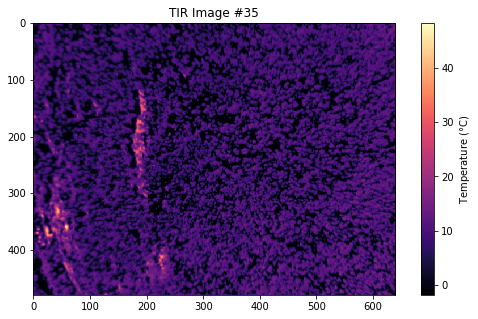

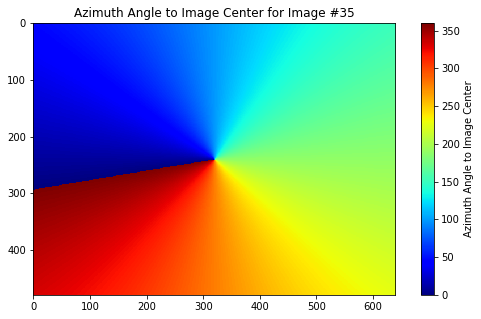

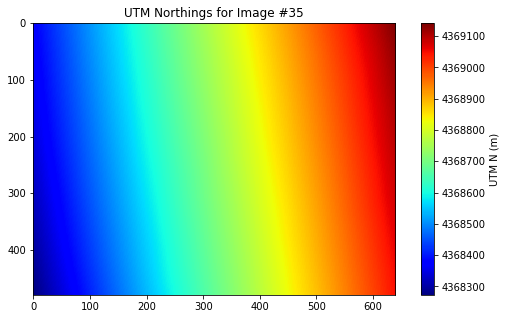

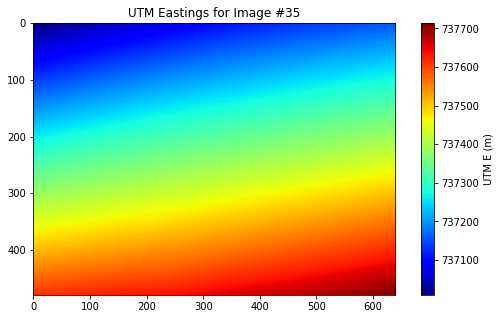

In [123]:
n=35

plt.figure(3,figsize=(9,5))
plt.imshow(img_temp_data[n],cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Temperature ($\degree$C)')
plt.title('TIR Image #{}'.format(n))

plt.figure(0,figsize=(9,5))
plt.imshow(azmuth_angles[n],cmap='jet',vmin=0,vmax=360)
cbar = plt.colorbar()
cbar.set_label('Azimuth Angle to Image Center')
plt.title('Azimuth Angle to Image Center for Image #{}'.format(n))


plt.figure(1,figsize=(9,5))
plt.imshow(image_utmn_data[n],cmap='jet')
cbar = plt.colorbar()
cbar.set_label('UTM N (m)')
plt.title('UTM Northings for Image #{}'.format(n))


plt.figure(2,figsize=(9,5))
plt.imshow(image_utme_data[n],cmap='jet')
cbar = plt.colorbar()
cbar.set_label('UTM E (m)')
plt.title('UTM Eastings for Image #{}'.format(n));

#### Plot mean temperature across azimuth angles for all images

Text(0,0.5,'Mean Image Temperature ($\\degree$C)')

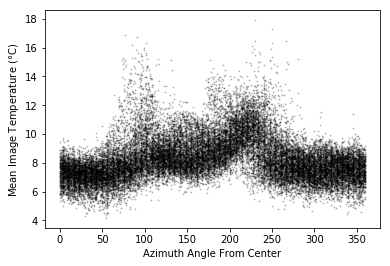

In [124]:
plt.figure(0)
plt.scatter(x_all,y_all,s=1,c='k',alpha=0.2)
plt.xlabel('Azimuth Angle From Center')
plt.ylabel('Mean Image Temperature ($\degree$C)')
#plt.savefig('mean_vs_AzimuthAngle_all.png',dpi=600)

#### Make a windrose-like plot of temperature (Figure S7):


(-21.0, 21.0, -21.0, 21.0)

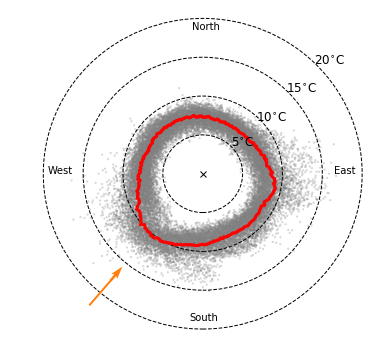

In [129]:
def pol2cart(rho, phi, rotate):
    # given a point's polar coordinates rho (radial distance), phi (clockwise azimuth angle), 
    # and rotate (angle to add to phi to put 0 degrees at the top like a compass)
    #https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
    x = rho * np.cos(np.radians(-phi+rotate))
    y = rho * np.sin(np.radians(-phi+rotate))
    return(x, y)

azis = np.array(x_all) # azimuth angles
temps = np.array(y_all) # temperatures

rotate = 90 # to orient 0 degrees, North, up

# for all data
x,y = pol2cart(temps,azis,rotate) 

# average by 1 degree bins
azis_1deg = np.round(azis,0)
temps_1deg = []
for a in range(0,360):
    temps_1deg.append(np.mean(temps[azis_1deg == a]))
x_1deg,y_1deg = pol2cart(temps_1deg,np.array(range(0,360)),rotate) 

fig,ax = plt.subplots(figsize=(6,6))

ax.plot(0,0,'x',color='k')
circle5 = plt.Circle((0, 0), 5, color='k', fill=False, linestyle='--')
circle10 = plt.Circle((0, 0), 10, color='k', fill=False, linestyle='--')
circle15 = plt.Circle((0, 0), 15, color='k', fill=False, linestyle='--')
circle20 = plt.Circle((0, 0), 20, color='k', fill=False, linestyle='--')
ax.add_artist(circle5)
ax.add_artist(circle10)
ax.add_artist(circle15)
ax.add_artist(circle20)
plt.text(3.5,3.5,'5$^{\circ}$C',color='k',fontsize=12)
plt.text(6.7,6.7,'10$^{\circ}$C',color='k',fontsize=12)
plt.text(10.4,10.4,'15$^{\circ}$C',color='k',fontsize=12)
plt.text(14,14,'20$^{\circ}$C',color='k',fontsize=12)

north_x, north_y = pol2cart(18.5,356,rotate)
south_x, south_y = pol2cart(19,185,rotate)
east_x, east_y = pol2cart(16.5,90,rotate)
west_x, west_y = pol2cart(19.5,270,rotate)
plt.text(north_x,north_y,'North')
plt.text(south_x,south_y,'South')
plt.text(east_x,east_y,'East')
plt.text(west_x,west_y,'West')

# Direction of sunlight in this afternoon was about S40W, or 220 degrees.
sun_x, sun_y = pol2cart(22,220,rotate)
sun_x2, sun_y2 = pol2cart(18,220,rotate)
plt.quiver(sun_x2,sun_y2,-sun_x2,-sun_y2,color='tab:orange',label='Sunlight Direction')
plt.plot([sun_x,sun_x2],[sun_y,sun_y2],'-',linewidth='2',color='tab:orange')

ax.scatter(x,y,s=5,alpha=0.3,facecolors='tab:gray', edgecolors='none',label='Temperature per 1$^{\circ}$ azimuth bin');
ax.scatter(x_1deg,y_1deg,s=10,alpha=1,facecolors='r', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
plt.xlim((-21,21))
plt.ylim((-21,21))
plt.axis('off')
#plt.legend(loc='lower right')
#plt.savefig('polar_plot_mean_vs_AzimuthAngle_all_greaterthan1C.png',dpi=600)

***
***